In [1]:
import numpy as np

class HyperspectralSegmentation:
    """
    Class for Supervised Hyperspectral Segmentation

    Input:  Signature Matrix M: (n_bands, n_end)
            Hyperspectral Image Output r: (nx, ny, n_bands)
    Output: Segmented Hyperspectral Image measure_cube: (nx, ny, n_end)
            Relative Spectral Discriminatory Entropy rdse_matrix: (nx,ny)
    """

    def __init__(self, M, r):
        # Getting nx,ny and n_bands
        self.nx, self.ny, self.n_bands = r.shape
        # Getting n_end
        self.n_end = M.shape[1]
        # This is the input signature matrix
        self.M = M
        # This is the desired output hyperspectral image cube
        self.r = r
        # This is the total number of pixels
        self.num_pixels = self.nx * self.ny

    @staticmethod
    def __calc_sam(reference_spectra, pixel_spectra) -> float:
        """
        Calculates the Spectral Angle Mapper measure, the similarity of test pixel spectra to known endmember spectra
        This similarity in radians is calculated as the relative angle between the two vectors in n-dimensional space
        :param reference_spectra: a (n_bands,) vector corresponding to the reference endmember spectra
        :param pixel_spectra: a (n_bands,) vector corresponding to the test spectra
        :return sam_measure: Spectral Angle Mapper Measure
        """
        # Calculates the norm of both vectors
        reference_spectra_norm = np.linalg.norm(reference_spectra)
        pixel_spectra_norm = np.linalg.norm(pixel_spectra)
        # Calculates the cosine distance between both vectors
        cosine_distance = np.dot(pixel_spectra, reference_spectra) / (reference_spectra_norm * pixel_spectra_norm)
        # Calculates the SAM measure between both vectors
        sam_measure = np.arccos(cosine_distance)
        return sam_measure

    @staticmethod
    def __calc_sid(reference_spectra, pixel_spectra) -> float:
        """
        Calculates the Spectral Information Divergence measure, the similarity of test pixel to known endmembers.
        The spectral signatures are viewed as probability distributions and using information theory their probabilistic
        distance is calculated for each band. Then the distance is averages with respect to each probability distribution
        and the value is symmetric.
        :param reference_spectra: a (n_bands,) vector corresponding to the reference endmember spectra
        :param pixel_spectra: a (n_bands,) vector corresponding to the test spectra
        :return sid_measure: Spectral Information Discrimination Measure
        """
        # calculates the discrete probability distributions for the pixel and the reference spectras
        p = (pixel_spectra / np.sum(pixel_spectra)) + np.spacing(1)  # avoid division by zero
        q = (reference_spectra / np.sum(reference_spectra)) + np.spacing(1)  # avoid division by zero
        # Calculate the relative cross entropy of q with respect to p and vice versa in nats
        relative_entropy_pq = np.dot(p, np.log(np.divide(p, q)))
        relative_entropy_qp = np.dot(q, np.log(np.divide(q, p)))
        # calculate the spectral information divergence
        sid_measure = relative_entropy_pq + relative_entropy_qp
        return sid_measure

    @staticmethod
    def __calc_sidsin(reference_spectra, pixel_spectra) -> float:
        """
        Calculates the SID(sin) measure, the similarity of test pixel to known endmembers.
        Combines sid and sam using sin
        :param reference_spectra: a (n_bands,) vector corresponding to the reference endmember spectra
        :param pixel_spectra: a (n_bands,) vector corresponding to the test spectra
        :return sidsin_measure: SID-SAM sin Measure
        """
        sam = HyperspectralSegmentation.__calc_sam(reference_spectra, pixel_spectra)
        sid = HyperspectralSegmentation.__calc_sid(reference_spectra, pixel_spectra)
        sidsin_measure = sid * np.sin(sam)

        return sidsin_measure

    @staticmethod
    def __calc_sidtan(reference_spectra, pixel_spectra) -> float:
        """
        Calculates the SID(tan) measure, the similarity of test pixel to known endmembers.
        Combines sid and sam using tan
        :param reference_spectra: a (n_bands,) vector corresponding to the reference endmember spectra
        :param pixel_spectra: a (n_bands,) vector corresponding to the test spectra
        :return sidtan_measure: SID-SAM tan Measure
        """
        sam = HyperspectralSegmentation.__calc_sam(reference_spectra, pixel_spectra)
        sid = HyperspectralSegmentation.__calc_sid(reference_spectra, pixel_spectra)
        sidtan_measure = sid * np.tan(sam)

        return sidtan_measure

    @staticmethod
    def __calc_entropy(spectral_measure) -> float:
        """
        Calculates the Spectral Discriminatory Entropy of Spectral Measure wrt a reference and test spectra
        Defined as the relative entropy within a normalized measure vector in base 2
        :return pixel_sde: The entropy across a pixel's endmember spectral measures
        """
        # Calculates the spectral discriminatory probability
        spectral_prob = spectral_measure / (np.sum(spectral_measure) + np.spacing(1))  # avoid division by zero
        # SDE = -Σp*log(p)
        pixel_sde = -np.dot(spectral_prob, np.log2(spectral_prob))
        return pixel_sde


    @staticmethod
    def __calc_discrim_pwr(spectral_measure1, spectral_measure2) -> float:
        """
        Calculates the Spectral Discriminatory Power of Spectral Measure wrt a reference and 2 test spectra
        Defined as the max of the ratios of the measure of the reference and one of the test spectra to the other
        :return pixel_dp: The discriminatory power between two spectral signatures with respect to a refrence specral signature
        """
        # Calculates the spectral discriminatory power
        ratio1 = spectral_measure1 / (spectral_measure2 + np.spacing(1))  # avoid division by zero
        ratio2 = spectral_measure2 / (spectral_measure1 + np.spacing(1))  # avoid division by zero
        pixel_dp = max(ratio1, ratio2)
        return pixel_dp

    @staticmethod
    def __calc_jmsam(reference_spectra, pixel_spectra, option="SIN") -> float:
        """
        Calculates the Jeffries Matusita and Spectral Angle Mapper Mixed Measure.
        :param reference_spectra: a (n_bands,) vector corresponding to the reference endmember spectra
        :param pixel_spectra: a (n_bands,) vector corresponding to the test spectra
        :param option: apply SIN/TAN to the SAM angle, default is SIN
        :return jmsam_measure: JMSAM
        """
        # calculate the discrete probability distribution vectors p and q
        p = (pixel_spectra / np.sum(pixel_spectra)) + np.spacing(1)
        q = (reference_spectra / np.sum(reference_spectra)) + np.spacing(1)

        # calculates the JM distance between p and q
        jmd = np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))

        # calculates SIN(SAM) or TAN(SAM)
        if option == "SIN":
            sam = np.sin(HyperspectralSegmentation.__calc_sam(reference_spectra, pixel_spectra))
        elif option == "TAN":
            sam = np.tan(HyperspectralSegmentation.__calc_sam(reference_spectra, pixel_spectra))

        return jmd * sam

    @staticmethod
    def __calc_ns3(reference_spectra, pixel_spectra, a_min, a_max) -> float:
        """
        Calculates the Normalized spectral similarity score. This is a mixed measure between SAM and spectral amplitude
        difference. The COS one is from a paper.
        :param reference_spectra: a (n_bands,) vector corresponding to the reference endmember spectra
        :param pixel_spectra: a (n_bands,) vector corresponding to the test spectra
        :param a_min: minimum spectral amplitude in image
        :param a_max: maximum spectral amplitude in image
        :return NS3_measure: NS3
        """
        # Get the number of bands N
        n = np.shape(reference_spectra)[0]

        # calculate the spectral amplitude difference A
        a = np.sqrt(np.sum((pixel_spectra - reference_spectra) ** 2) / n)
        # calculate normilized spectral amplituded difference
        a_norm = (a - a_min) / (a_max - a_min)
        # calculates 1-cos(SAM)
        sam = 1 - np.cos(HyperspectralSegmentation.__calc_sam(reference_spectra, pixel_spectra))
    
        # calculates Ns3 score
        NS3_measure = np.sqrt((a_norm ** 2) + sam ** 2)
        
        return NS3_measure
   
    def SpectralAngleMapper(self):
        """
        Spectral Angle Mapper Classifier classifies a hyperspectral cube according to the SAM measure
        Output: Segmented Hyperspectral Image spectral_angle_cube: (nx, ny, n_end)
                Spectral Discriminatory Entropy sde_matrix: (nx,ny)
        """
        spectral_angle_cube = np.zeros(shape=(self.nx, self.ny, self.n_end))
        sde_matrix = np.zeros(shape=(self.nx, self.ny))

        for i in range(self.nx):
            for j in range(self.ny):
                # Grabbing the test pixel spectra across all the bands
                pixel_spectra = self.r[i, j, :]
                # Looping through each endmember reference spectra in M
                for k in range(self.n_end):
                    # Grabbing the reference pixel spectra
                    endmember_spectra = self.M[:, k]
                    spectral_angle_cube[i, j, k] = self.__calc_sam(endmember_spectra, pixel_spectra)

                # calculates the RDSE for the pixel's SAM measure
                sde_matrix[i, j] = self.__calc_entropy(spectral_angle_cube[i, j, :])

        return spectral_angle_cube, sde_matrix

    def SpectralInformationDivergence(self):
        """
        Spectral Information Divergence Classifier classifies a hyperspectral cube according to the SID measure
        Output: Spectral Divergence Measure Cube spectral_divergence_cube: (nx, ny, n_end)
                Spectral Discriminatory Entropy sde_matrix: (nx,ny)
        """
        spectral_divergence_cube = np.zeros(shape=(self.nx, self.ny, self.n_end))
        sde_matrix = np.zeros(shape=(self.nx, self.ny))

        for i in range(self.nx):
            for j in range(self.ny):
                # Grabbing the test pixel spectra across all the bands
                pixel_spectra = self.r[i, j, :]

                # Looping through each endmember reference spectra in M
                for k in range(self.n_end):
                    # Grabbing the reference pixel spectra
                    endmember_spectra = self.M[:, k]
                    # Calculating Inserting the measure value into the cube
                    spectral_divergence_cube[i, j, k] = self.__calc_sid(endmember_spectra, pixel_spectra)

                # calculates the RDSE for the pixel's SID measure
                sde_matrix[i, j] = self.__calc_entropy(spectral_divergence_cube[i, j, :])

        return spectral_divergence_cube, sde_matrix

    def SpectralMixedMeasure(self, option="SIN"):
        """
        The SID - SAM Mixed Measure combines both Spectral Angle Mapper and Spectral Information Divergence into a new
        measure. This measure has two versions for a pixel spectra r and an endmember reference spectra s:
                SID(SIN) = SID(r,s)*sin(SAM(r,s))  and SID(TAN) = SID(r,s)*tan(SAM(r,s))
        Input: option: "SIN" or "TAN"
        Output: Spectral Mixed Measure Cube spectral_mixed_cube: (nx, ny, n_end)
                Spectral Discriminatory Entropy sde_matrix: (nx,ny)
        """
        spectral_mixed_cube = np.zeros(shape=(self.nx, self.ny, self.n_end))
        sde_matrix = np.zeros(shape=(self.nx, self.ny))

        for i in range(self.nx):
            for j in range(self.ny):
                # Grabbing the test pixel spectra across all the bands
                pixel_spectra = self.r[i, j, :]

                # Looping through each endmember reference spectra in M
                for k in range(self.n_end):
                    # Grabbing the reference pixel spectra
                    endmember_spectra = self.M[:, k]
                    # Calculating the SAM and SID measures
                    sam_measure = self.__calc_sam(endmember_spectra, pixel_spectra)
                    sid_measure = self.__calc_sid(endmember_spectra, pixel_spectra)

                    # Calculating the SID-SAM mixed measure according to user preference
                    mixed_measure = 0
                    if option == "SIN":
                        mixed_measure = sid_measure * np.sin(sam_measure)
                    elif option == "TAN":
                        mixed_measure = sid_measure * np.tan(sam_measure)

                    # Inserting the mixed_measure value into the cube
                    spectral_mixed_cube[i, j, k] = mixed_measure

                # calculates the RDSE for the pixel's SIDSAM measure
                sde_matrix[i, j] = self.__calc_entropy(spectral_mixed_cube[i, j, :])

        # Finding the endmember with the lowest SAM value across n_end axis
        return spectral_mixed_cube, sde_matrix

    def JMSAMMixedMeasure(self, option="SIN"):
        """
        Jeffries Matusita and Spectral Angle Mapper classifier classifies a hyperspectral cube according to the JMSAM
        Output: Spectral Divergence Measure Cube spectral_divergence_cube: (nx, ny, n_end)
                Spectral Discriminatory Entropy sde_matrix: (nx,ny)
        """
        jmsam_cube = np.zeros(shape=(self.nx, self.ny, self.n_end))
        sde_matrix = np.zeros(shape=(self.nx, self.ny))

        for i in range(self.nx):
            for j in range(self.ny):
                # Grabbing the test pixel spectra across all the bands
                pixel_spectra = self.r[i, j, :]
                # Looping through each endmember reference spectra in M
                for k in range(self.n_end):
                    # Grabbing the reference pixel spectra
                    endmember_spectra = self.M[:, k]
                    # Calculating and inserting the measure value into the cube
                    if option == "SIN":
                        jmsam_cube[i, j, k] = self.__calc_jmsam(endmember_spectra, pixel_spectra)
                    elif option == "TAN":
                        jmsam_cube[i, j, k] = self.__calc_jmsam(endmember_spectra, pixel_spectra, option="TAN")

                # calculates the RDSE for the pixel's SID measure
                sde_matrix[i, j] = self.__calc_entropy(jmsam_cube[i, j, :])

        return jmsam_cube, sde_matrix

    def NS3(self):
        """
        NS3 classifier classifies a hyperspectral cube according to the normalized spectral similarity score
        Output: Spectral Divergence Measure Cube spectral_divergence_cube: (nx, ny, n_end)
                Spectral Discriminatory Entropy sde_matrix: (nx,ny)
        """
        ns3_cube = np.zeros(shape=(self.nx, self.ny, self.n_end))
        sde_matrix = np.zeros(shape=(self.nx, self.ny))


        # calculate ns3 score for every pixel
        for i in range(self.nx):
            for j in range(self.ny):
                # Grabbing the test pixel spectra across all the bands
                pixel_spectra = self.r[i, j, :]
                # determine minimum and maximum spectral ampilitude difference for each pixel
                a = np.zeros(self.n_end)
                index = 0
                # Get the number of bands N
                n = self.n_bands
                # Looping through each endmember reference spectra in M
                for k in range(self.n_end):
                    # Grabbing the reference pixel spectra
                    endmember_spectra = self.M[:, k]
                    a[index] = np.sqrt(np.sum((pixel_spectra - endmember_spectra) ** 2)/n)
                    index += 1
                a_min = np.min(a)
                a_max = np.max(a)
                # Looping through each endmember reference spectra in M
                for k in range(self.n_end):
                    # Grabbing the reference pixel spectra
                    endmember_spectra = self.M[:, k]
                    # Calculating and inserting the measure value into the cube
                    ns3_cube[i, j, k] = self.__calc_ns3(endmember_spectra, pixel_spectra, a_min, a_max)


                # calculates the RDSE for the pixel's SID measure
                sde_matrix[i, j] = self.__calc_entropy(ns3_cube[i, j, :])

        return ns3_cube, sde_matrix

    def DiscriminatoryPower(self, test1, test2, reference, measure):
        """
        The Discriminatory power determins the ability of a measure to distinguish between two sprectra with
        respect to a third. This measure is the max between the ratios of the measure of test1 and reference vs
        the measure of test2 and reference.

        Input:  test1: test spectral signature one
                test2: test spectral signature two
                reference: reference spectral signature
                measure: "SAM", "SID", "SID(SIN)", "SID(TAN)", "JMSAM(SIN)", "JMSAM(TAN)", "NS3"
        Output: Spectral Mixed Measure Cube spectral_mixed_cube: (nx, ny, n_end)
                Spectral Discriminatory Entropy sde_matrix: (nx,ny)
        """
        # initializing spectral meausres
        spectral_measure1 = 0
        spectral_measure2 = 0
        # calculating spectral measures based on measure input
        if measure == "SAM":
            spectral_measure1 = self.__calc_sam(reference, test1)
            spectral_measure2 = self.__calc_sam(reference, test2)
        elif measure == "SID":
            spectral_measure1 = self.__calc_sid(reference, test1)
            spectral_measure2 = self.__calc_sid(reference, test2)
        elif measure == "SID(SIN)":
            spectral_measure1 = self.__calc_sidsin(reference, test1)
            spectral_measure2 = self.__calc_sidsin(reference, test2)
        elif measure == "SID(TAN)":
            spectral_measure1 = self.__calc_sidtan(reference, test1)
            spectral_measure2 = self.__calc_sidtan(reference, test2)
        elif measure == "JMSAM(SIN)":
            spectral_measure1 = self.__calc_jmsam(reference, test1)
            spectral_measure2 = self.__calc_jmsam(reference, test2)
        elif measure == "JMSAM(TAN)":
            spectral_measure1 = self.__calc_jmsam(reference, test1, option="TAN")
            spectral_measure2 = self.__calc_jmsam(reference, test2, option="TAN")
        elif measure == "NS3":
            # determine minimum and maximum spectral ampilitude difference for test 1 and test 2
            a1 = np.zeros(self.n_end)
            a2 = np.zeros(self.n_end)
            index = 0
            # Get the number of bands N
            n = self.n_bands
            # Looping through each endmember reference spectra in M
            for k in range(self.n_end):
                # Grabbing the reference pixel spectra
                endmember_spectra = self.M[:, k]
                a1[index] = np.sqrt(np.sum((test1 - endmember_spectra) ** 2) / n)
                a2[index] = np.sqrt(np.sum((test2 - endmember_spectra) ** 2) / n)
                index += 1
            a1_min = np.min(a1)
            a1_max = np.max(a1)
            a2_min = np.min(a2)
            a2_max = np.max(a2)

            spectral_measure1 = self.__calc_ns3(reference, test1, a1_min, a1_max)
            spectral_measure2 = self.__calc_ns3(reference, test2, a2_min, a2_max)
        # calculate discriminaory power
        dp = self.__calc_discrim_pwr(spectral_measure1, spectral_measure2)
        return dp

In [2]:
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib


class HyperspectralVisualizer:
    """
    This is a class that handles Hyperspectral Data Visualization
    Input: Hyperspectral Image Cube hcube: (nx, ny, nz)
    Alternative Input: Hyperspectral Image himg: (nx, ny)
    Output: matplotlib Figure fig
    """

    def __init__(self, hcube=None, himg=None):
        # If an himg is inputted, prioritize that and reshape it
        if himg is not None:
            self.nx, self.ny = himg.shape
            self.nz = 1
            # Reshapes image into 3d hypercube with 1 layer
            self.hcube = himg.reshape(self.nx, self.ny, self.nz)
        else:
            self.nx, self.ny, self.nz = hcube.shape
            self.hcube = hcube

    def layer_plot(self, title='Default Title', subtitle='Default Subtitle', display_figure_labels=False,
                       figure_labels=None, font_size=8, subplot_dims=None, color_map='viridis',
                       color_map_bounds=None, colormap_discrete = False, colormap_num_discrete = None) -> matplotlib.figure:
        """
        Creates a 2D plot of a Hyperspectral Cube displaying the layers along the n_z axis
        :return fig: A matplotlib figure
        :param title: Main Title (Default: "Default Title")
        :param subtitle: Subtitle (Default: "Default Subtitle")
        :param display_figure_labels: Whether to display figure labels or not
        :param figure_labels: Figure Labels as a list of strings for the number of plots needed, otherwise, display
                              figure labels as "Layer x" instead
        :param font_size: Font Size (Default: 8pt)
        :param subplot_dims: Desired subplot dimensions in a tuple (dim_x,dim_y). The tuple must accommodate the size
                             of x.shape[2] (Default: None)
        :param color_map: Known matplotlib colormap (Default: "viridis")
        :param color_map_bounds: Bounds of the Colormap in a tuple (lb,ub), if no value is given, maximum/minimum values
                                 will be chosen from the cube
        :param colormap_discrete: Display a discrete colormap (Default: False)
        :param colormap_num_discrete: Number of discrete colormap values                   
        """
        # Setting matplotlib style config to fast
        mplstyle.use("fast")
        # Setting overall font-size and colormap for the plot
        plt.rcParams.update({'font.size': font_size})

        cmap = matplotlib.cm.get_cmap(color_map)
        if colormap_discrete and colormap_num_discrete is not None:
            cmap = matplotlib.cm.get_cmap(color_map, colormap_num_discrete)

        # If no subplot dimensions are specified/ are not adequate, create new dimensions
        if (subplot_dims is None) or (subplot_dims[0] * subplot_dims[1] < self.nz):
            # Manually calculating the dimensions of the subplot
            dim_x, dim_y = 1, 1
            while dim_x * dim_y < self.nz:
                if dim_y <= dim_x:
                    dim_y += 1
                else:
                    dim_x += 1
        else:
            dim_x, dim_y = subplot_dims

        # If no colormap_bounds are specified, create new ones
        if color_map_bounds is None:
            color_map_bounds = (float(np.amin(self.hcube)), float(np.amax(self.hcube)))

        # Defining a new figure with subplots in a (subplot_dims[0], subplot_dims[1]) grid
        fig, axes = plt.subplots(nrows=dim_x, ncols=dim_y, squeeze=False, constrained_layout=False)
        # Looping through each subplot, stopping adding photos when plots outnumber n_z
        n_plotted = 0
        for i in range(axes.shape[0]):
            for j in range(axes.shape[1]):
                if n_plotted < self.nz:
                    # Adding the images to the subplot and setting a title
                    im = axes[i, j].imshow(self.hcube[:, :, n_plotted], vmin=color_map_bounds[0],
                                           vmax=color_map_bounds[1], cmap = cmap)
                    # Setting a subplot figure label if desired
                    if display_figure_labels:
                        if figure_labels is not None:
                            axes[i, j].set_title(figure_labels[n_plotted])
                        else:
                            axes[i, j].set_title("Layer" + " " + str(n_plotted + 1))
                    n_plotted += 1
                else:
                    axes[i, j].set_axis_off()
        # Display title and subtitle and colormaps
        plt.suptitle(title + "\n" + subtitle)
        fig.colorbar(im, ax=axes.ravel().tolist())
        return fig

    def cube_plot(self, title="Default Title", subtitle="Default Subtitle", color_map="viridis"):
        """
        Plots a 3D cube using surface plots along the n_z axis
        :return fig: A matplotlib figure
        :param title: Main Title (Default: "Default Title")
        :param subtitle: Subtitle (Default: "Default Subtitle")
        :param color_map: Known matplotlib colormap (Default: "viridis")
        """
        # Sets the plotting speed to fast and grabs the builtin matplotlib colormap
        mplstyle.use('fast')
        cmap = plt.cm.get_cmap(color_map)

        # Creating a mesh grid to map every single pixel in one 2D layer
        mesh_x, mesh_y = np.meshgrid(np.arange(self.nx + 1)[::-1], np.arange(self.ny + 1))
        # Creating and populating a figure
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_box_aspect([1, 1, 1])
        # for each layer in the cube,
        for i in range(self.nz):
            # Creating the flat height matrix for the layer
            mesh_z = ((self.nz - i) / self.nz) * np.ones((self.ny + 1, self.nx + 1))
            im = ax.plot_surface(mesh_y, mesh_x, mesh_z, shade=False, cstride=2, rstride=2,
                                 facecolors=cmap(np.reshape(self.hcube[:, :, i], (self.nx, self.ny)).T))
        # Displaying the titles and color maps
        plt.suptitle(title + "\n" + subtitle)
        fig.colorbar(im, ax=ax)
        return fig
    
    def layer_plot2(self, title='Default Title', subtitle='Default Subtitle', display_figure_labels=False,
                       figure_labels=None, font_size=8, subplot_dims=None, color_map='viridis',
                       color_map_bounds=None, colormap_discrete = False, colormap_num_discrete = None) -> matplotlib.figure:
        """
        Creates a 2D plot of a Hyperspectral Cube displaying the layers along the n_z axis
        :return fig: A matplotlib figure
        :param title: Main Title (Default: "Default Title")
        :param subtitle: Subtitle (Default: "Default Subtitle")
        :param display_figure_labels: Whether to display figure labels or not
        :param figure_labels: Figure Labels as a list of strings for the number of plots needed, otherwise, display
                              figure labels as "Layer x" instead
        :param font_size: Font Size (Default: 8pt)
        :param subplot_dims: Desired subplot dimensions in a tuple (dim_x,dim_y). The tuple must accommodate the size
                             of x.shape[2] (Default: None)
        :param color_map: Known matplotlib colormap (Default: "viridis")
        :param color_map_bounds: Bounds of the Colormap in a tuple (lb,ub), if no value is given, maximum/minimum values
                                 will be chosen from the cube
        :param colormap_discrete: Display a discrete colormap (Default: False)
        :param colormap_num_discrete: Number of discrete colormap values                   
        """
        # Setting matplotlib style config to fast
        mplstyle.use("fast")
        # Setting overall font-size and colormap for the plot
        plt.rcParams.update({'font.size': font_size})

        cmap = matplotlib.cm.get_cmap(color_map)
        if colormap_discrete and colormap_num_discrete is not None:
            cmap = matplotlib.cm.get_cmap(color_map, colormap_num_discrete)

        # If no subplot dimensions are specified/ are not adequate, create new dimensions
        if (subplot_dims is None) or (subplot_dims[0] * subplot_dims[1] < self.nz):
            # Manually calculating the dimensions of the subplot
            dim_x, dim_y = 1, 1
            while dim_x * dim_y < self.nz:
                if dim_y <= dim_x:
                    dim_y += 1
                else:
                    dim_x += 1
        else:
            dim_x, dim_y = subplot_dims

        # If no colormap_bounds are specified, create new ones
        if color_map_bounds is None:
            color_map_bounds = (float(np.amin(self.hcube)), float(np.amax(self.hcube)))
        
        # Defining a new figure with subplots in a (subplot_dims[0], subplot_dims[1]) grid
        num_rows = int(np.ceil(np.sqrt(4)))
        num_cols = int(np.ceil(4/ num_rows))
        fig, axes = plt.subplots(nrows=num_rows, ncols = num_cols, squeeze=False, constrained_layout=False)
    
        # Looping through each subplot, stopping adding photos when plots outnumber n_z
        n_plotted = 0
        for i in range(axes.shape[0]):
            for j in range(axes.shape[1]):
                if n_plotted < 4:
                    # Adding the images to the subplot and setting a title
                    im = axes[i, j].imshow(self.hcube[:, :, n_plotted], vmin=color_map_bounds[0],
                                           vmax=color_map_bounds[1], cmap = cmap)
                    # Setting a subplot figure label if desired
                    if display_figure_labels:
                        if figure_labels is not None:
                            axes[i, j].set_title(figure_labels[n_plotted])
                        else:
                            axes[i, j].set_title("Layer" + " " + str(n_plotted + 1))
                    n_plotted += 1
                else:
                    axes[i, j].set_axis_off()
        
        # Display title and subtitle and colormaps
        plt.suptitle(title + "\n" + subtitle)
        fig.colorbar(im, ax=axes.ravel().tolist())
        return fig

In [3]:
import scipy.io
# Load Dataset
hyperspectral_data = scipy.io.loadmat('Dataset/eye1.mat')
# data_gt=scipy.io.loadmat('Dataset/urban_end6_gt.mat')
# Get Signature Matrix M
# signature_matrix = data_gt["M"]
# Get the desired output Hyperspectral Image Cube r
hyperspectral_cube = hyperspectral_data['Datacube']

## Band 10 Image

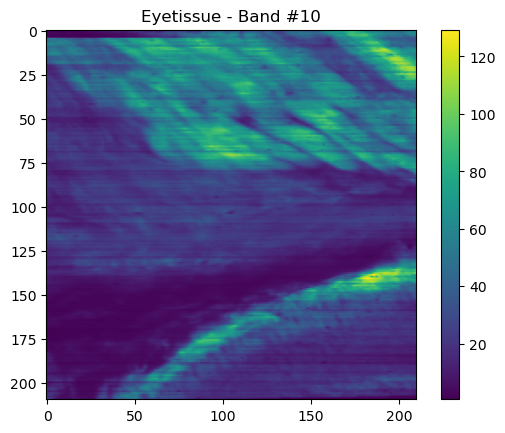

In [21]:
plt.imshow(hyperspectral_cube[:, :, 9], cmap="viridis")
plt.colorbar()
plt.title('Eyetissue - Band #10')
plt.show()

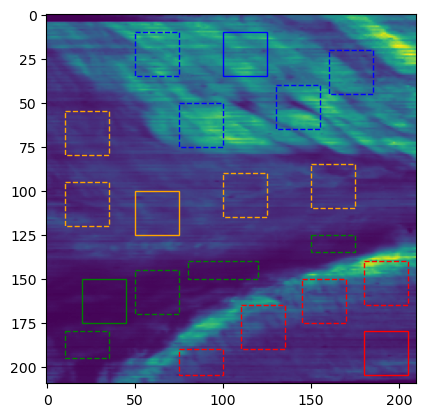

In [435]:
fig, ax = plt.subplots()
ax.imshow(hyperspectral_cube[:, :, 29], cmap="viridis")
#plt.imshow(hyperspectral_cube[:, :, 29], cmap="viridis")
#muscle
rect1 = patches.Rectangle((100, 10), 25, 25, linewidth=1, edgecolor='b', facecolor='none')
rect1a = patches.Rectangle((130, 40), 25, 25, linewidth=1, edgecolor='b', linestyle = '--',facecolor='none')
rect1b = patches.Rectangle((50, 10), 25, 25, linewidth=1, edgecolor='b', linestyle = '--',facecolor='none')
rect1c = patches.Rectangle((75, 50), 25, 25, linewidth=1, edgecolor='b', linestyle = '--',facecolor='none')
rect1d = patches.Rectangle((160, 20), 25, 25, linewidth=1, edgecolor='b', linestyle = '--',facecolor='none')

#sclera
rect2 = patches.Rectangle((50, 100), 25, 25, linewidth=1, edgecolor='orange', facecolor='none')
rect2a = patches.Rectangle((100, 90), 25, 25, linewidth=1, edgecolor='orange', linestyle = '--',facecolor='none')
rect2b = patches.Rectangle((10, 55), 25, 25, linewidth=1, edgecolor='orange', linestyle = '--',facecolor='none')
rect2c = patches.Rectangle((10, 95), 25, 25, linewidth=1, edgecolor='orange', linestyle = '--',facecolor='none')
rect2d = patches.Rectangle((150, 85), 25, 25, linewidth=1, edgecolor='orange', linestyle = '--',facecolor='none')
#choroid
rect3 = patches.Rectangle((20, 150), 25, 25, linewidth=1, edgecolor='g', facecolor='none')
rect3a = patches.Rectangle((50, 145), 25, 25, linewidth=1, edgecolor='g', linestyle = '--',facecolor='none')
rect3b = patches.Rectangle((10, 180), 25, 15, linewidth=1, edgecolor='g', linestyle = '--',facecolor='none')
rect3c = patches.Rectangle((150, 125), 25, 10, linewidth=1, edgecolor='g', linestyle = '--',facecolor='none')
rect3d = patches.Rectangle((80, 140), 40, 10, linewidth=1, edgecolor='g', linestyle = '--',facecolor='none')
#retina
rect4 = patches.Rectangle((180, 180), 25, 25, linewidth=1, edgecolor='r', facecolor='none')
rect4a = patches.Rectangle((110, 165), 25, 25, linewidth=1, edgecolor='r', linestyle = '--',facecolor='none')
rect4b = patches.Rectangle((180, 140), 25, 25, linewidth=1, edgecolor='r', linestyle = '--',facecolor='none')
rect4c = patches.Rectangle((75, 190), 25, 15, linewidth=1, edgecolor='r', linestyle = '--',facecolor='none')
rect4d = patches.Rectangle((145, 150), 25, 25, linewidth=1, edgecolor='r', linestyle = '--',facecolor='none')

rects = [rect1, rect2, rect3, rect4, rect1a, rect1b, rect1c, rect1d, rect2a, rect2b, rect2c, rect2d,rect3a, rect3b, rect3c, rect3d, rect4a, rect4b, rect4c, rect4d]
for i in rects:
    ax.add_patch(i)
plt.show()

## Estimated signatures for ROIs

In [344]:
def get_mean(*args):
    total_sums = [0] * len(args[0])
    total_counts = [0] * len(args[0])

    for array in args:
        for i, element in enumerate(array):
            total_sums[i] += element
            total_counts[i] += 1

    means = [total_sums[i] / total_counts[i] if total_counts[i] > 0 else 0 for i in range(len(total_sums))]
    return means

In [345]:
def get_roi(x, y, width, height):
    roi = []
    for j in range (x,x+width):
        for i in range (y, y+height):
            roi.append(hyperspectral_cube[i, j, :])
    return roi

In [436]:
muscle_mean1 = np.mean(get_roi(100, 10, 25, 25), axis=0)
muscle_mean2 = np.mean(get_roi(130, 40, 25, 25), axis=0)
muscle_mean3 = np.mean(get_roi(50, 10, 25, 25), axis=0)
muscle_mean4 = np.mean(get_roi(75, 50, 25, 25), axis=0)
muscle_mean5 = np.mean(get_roi(160, 20, 25, 25), axis=0)
muscle_all_mean = get_mean(muscle_mean1, muscle_mean2, muscle_mean3, muscle_mean4, muscle_mean5)

In [437]:
sclera_mean1 = np.mean(get_roi(50, 100, 25, 25), axis=0)
sclera_mean2 = np.mean(get_roi(100, 90, 25, 25), axis=0)
sclera_mean3 = np.mean(get_roi(10, 55, 25, 25), axis=0)
sclera_mean4 = np.mean(get_roi(10, 95, 25, 25), axis=0)
sclera_mean5 = np.mean(get_roi(150, 85, 25, 25), axis=0)
sclera_all_mean = get_mean(sclera_mean1, sclera_mean2, sclera_mean3, sclera_mean4, sclera_mean5)

In [438]:
choroid_mean1 = np.mean(get_roi(20, 150, 25, 25), axis=0)
choroid_mean2 = np.mean(get_roi(50, 145, 25, 25), axis=0)
choroid_mean3 = np.mean(get_roi(10, 180, 25, 15), axis=0)
choroid_mean4 = np.mean(get_roi(150, 125, 25, 10), axis=0)
choroid_mean5 = np.mean(get_roi(80, 140, 40, 10), axis=0)
choroid_all_mean = get_mean(choroid_mean1, choroid_mean2, choroid_mean3, choroid_mean4, choroid_mean5)

In [445]:
retina_mean1 = np.mean(get_roi(180, 180, 25, 25), axis=0)
retina_mean2 = np.mean(get_roi(110, 165, 25, 25), axis=0)
retina_mean3 = np.mean(get_roi(180, 140, 25, 25), axis=0)
retina_mean4 = np.mean(get_roi(75, 190, 25, 15), axis=0)
retina_mean5 = np.mean(get_roi(145, 150, 25, 25), axis=0)
retina_all_mean = get_mean(retina_mean1, retina_mean2, retina_mean3, retina_mean4, retina_mean5)

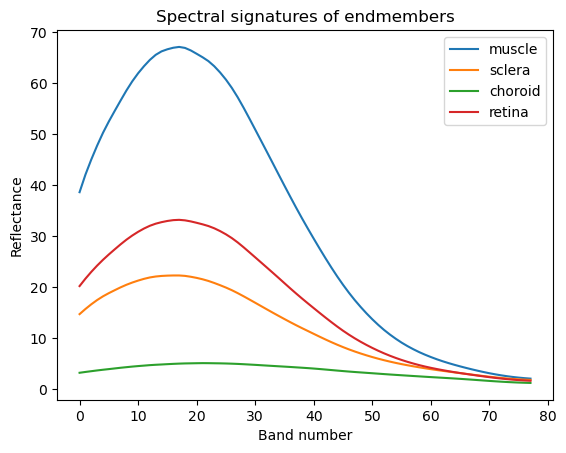

In [446]:
plots = [muscle_all_mean, sclera_all_mean, choroid_all_mean, retina_all_mean]
labs = ['muscle', 'sclera', 'choroid', 'retina']
for i in range(4):
    plt.plot(plots[i], label = labs[i])
plt.xlabel('Band number')
plt.ylabel('Reflectance')
plt.title('Spectral signatures of endmembers')
plt.legend()
plt.show()

## Segmentation

### All 4 endmembers

In [447]:
all_endmembers = np.column_stack((muscle_all_mean, sclera_all_mean, choroid_all_mean, retina_all_mean))

In [448]:
analytical = HyperspectralSegmentation(M = all_endmembers, r = hyperspectral_cube)

In [449]:
sidsam_tan = analytical.SpectralMixedMeasure(option="TAN")

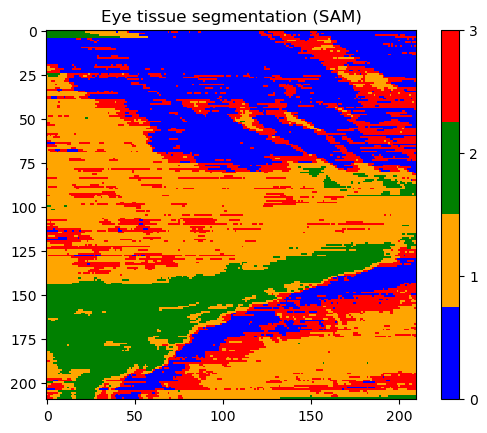

In [450]:
cmap_d = colors.ListedColormap(['blue', 'orange', 'green', 'red'])

plt.imshow(np.argmin(sidsam_tan[0],axis=2), cmap=cmap_d, interpolation='nearest')
plt.title("Eye tissue segmentation (SAM)")
plt.colorbar(ticks=np.arange(4), cmap=cmap_d)

plt.show()

### Muscle & Non-muscle

In [451]:
nonmuscle_all_mean = get_mean(sclera_all_mean, choroid_all_mean, retina_all_mean)

In [452]:
muscle_non_endmembers = np.column_stack((muscle_all_mean, nonmuscle_all_mean))

In [453]:
analyticalM = HyperspectralSegmentation(M = muscle_non_endmembers, r = hyperspectral_cube)

In [454]:
sidsam_tanM = analyticalM.SpectralMixedMeasure(option="TAN")

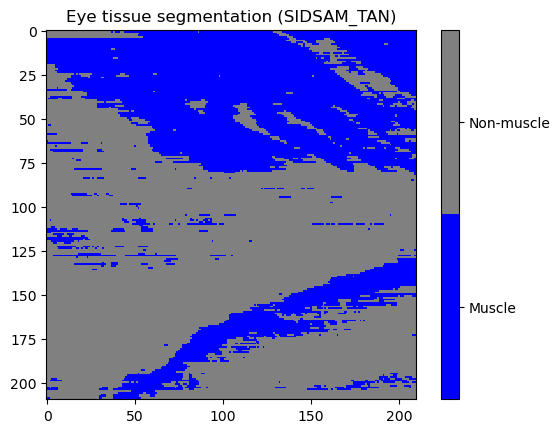

In [455]:
cmap = colors.ListedColormap(['blue', 'gray'])
muscle_class = np.argmin(sidsam_tanM[0],axis=2) 
plt.imshow(muscle_class, cmap=cmap, interpolation='nearest')
plt.title("Eye tissue segmentation (SIDSAM_TAN)")
cbar = plt.colorbar()
cbar.set_ticks([0.25,0.75]) 
cbar.set_ticklabels(['Muscle', 'Non-muscle'])
plt.show()

### Sclera & Non-sclera

In [456]:
nonsclera_all_mean = get_mean(muscle_all_mean, choroid_all_mean, retina_all_mean)

In [457]:
sclera_non_endmembers = np.column_stack((sclera_all_mean, nonsclera_all_mean))

In [458]:
analyticalS = HyperspectralSegmentation(M = sclera_non_endmembers, r = hyperspectral_cube)

In [459]:
sidsam_tanS = analyticalS.SpectralMixedMeasure(option="TAN")

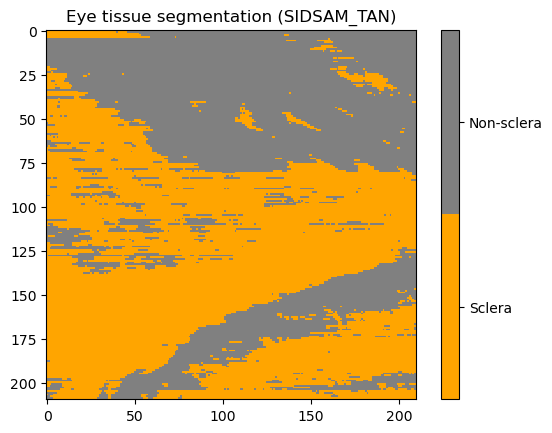

In [460]:
cmap = colors.ListedColormap(['orange', 'gray'])
sclera_class = np.argmin(sidsam_tanS[0],axis=2)
plt.imshow(sclera_class, cmap=cmap, interpolation='nearest')
plt.title("Eye tissue segmentation (SIDSAM_TAN)")
cbar = plt.colorbar()
cbar.set_ticks([0.25,0.75]) 
cbar.set_ticklabels(['Sclera', 'Non-sclera'])
plt.show()

### Choroid & Non-choroid

In [461]:
nonchoroid_all_mean = get_mean(muscle_all_mean, sclera_all_mean, retina_all_mean)

In [462]:
choroid_non_endmembers = np.column_stack((choroid_all_mean, nonchoroid_all_mean))

In [463]:
analyticalC = HyperspectralSegmentation(M = choroid_non_endmembers, r = hyperspectral_cube)

In [464]:
sidsam_tanC = analyticalC.SpectralMixedMeasure(option="TAN")

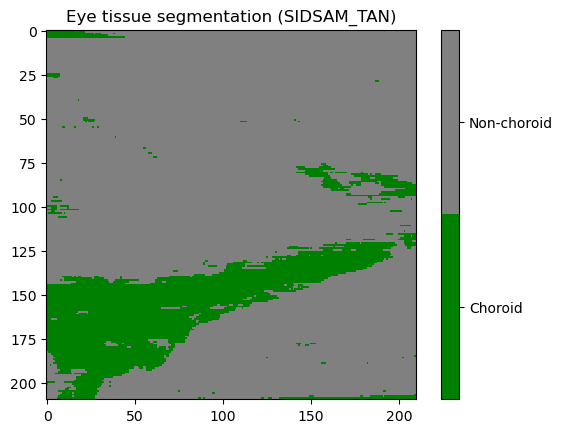

In [465]:
cmap = colors.ListedColormap(['green', 'gray'])
choroid_class = np.argmin(sidsam_tanC[0],axis=2)
plt.imshow(choroid_class, cmap=cmap, interpolation='nearest')
plt.title("Eye tissue segmentation (SIDSAM_TAN)")
cbar = plt.colorbar()
cbar.set_ticks([0.25,0.75]) 
cbar.set_ticklabels(['Choroid', 'Non-choroid'])
plt.show()

### Retina & Non-retina

In [466]:
nonretina_all_mean = get_mean(muscle_all_mean, sclera_all_mean, choroid_all_mean)

In [467]:
retina_non_endmembers = np.column_stack((retina_all_mean, nonretina_all_mean))

In [468]:
analyticalR = HyperspectralSegmentation(M = retina_non_endmembers, r = hyperspectral_cube)

In [469]:
sidsam_tanR = analyticalR.SpectralMixedMeasure(option="TAN")

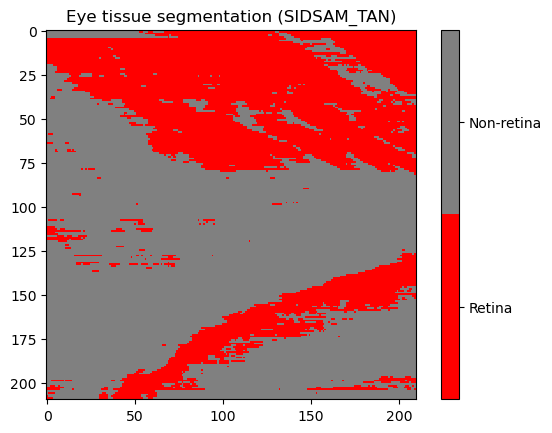

In [470]:
cmap = colors.ListedColormap(['red', 'gray'])
retina_class = np.argmin(sidsam_tanR[0],axis=2)
plt.imshow(retina_class, cmap=cmap, interpolation='nearest')
plt.title("Eye tissue segmentation (SIDSAM_TAN)")
cbar = plt.colorbar()
cbar.set_ticks([0.25,0.75]) 
cbar.set_ticklabels(['Retina', 'Non-retina'])
plt.show()

### Flood-fill

In [471]:

def connected_component_labeling(image, target_color):
    height, width = image.shape
    labels = np.zeros_like(image, dtype=int)
    current_label = 1
    stack = []

    def push_if_valid(x, y):
        if x >= 0 and y >= 0 and x < height and y < width and image[x, y] == target_color and labels[x, y] == 0:
            stack.append((x, y))

    for x in range(height):
        for y in range(width):
            if image[x, y] == target_color and labels[x, y] == 0:
                stack.append((x, y))
                while stack:
                    sx, sy = stack.pop()
                    if labels[sx, sy] == 0:
                        labels[sx, sy] = current_label
                        push_if_valid(sx - 1, sy)
                        push_if_valid(sx + 1, sy)
                        push_if_valid(sx, sy - 1)
                        push_if_valid(sx, sy + 1)
                current_label += 1

    hole_regions = []
    for label in range(1, current_label):
        hole_region = np.where(labels == label)
        hole_size = len(hole_region[0])
        hole_regions.append((hole_region, hole_size))

    return hole_regions

def flood_fill(image, x, y, target_color, replacement_color):
    stack = [(x, y)]
    filled_pixels = 0

    while stack:
        x, y = stack.pop()

        if image[x][y] != target_color:
            continue

        image[x][y] = replacement_color
        filled_pixels += 1

        if x > 0:
            stack.append((x - 1, y))
        if x < len(image) - 1:
            stack.append((x + 1, y))
        if y > 0:
            stack.append((x, y - 1))
        if y < len(image[0]) - 1:
            stack.append((x, y + 1))

    return filled_pixels

def fill_all_holes(image, target_color, replacement_color, max_hole_size):
    labeled_holes = connected_component_labeling(image, target_color)
    for hole_region, hole_size in labeled_holes:
        if hole_size <= max_hole_size:
            x_indices, y_indices = hole_region  # Get the row and column indices separately
            x, y = x_indices[0], y_indices[0]   # Choose a pixel within the hole region
            flood_fill(image, x, y, target_color, replacement_color)



In [398]:
def invert_matrix(matrix):
    # Create a new matrix to store the inverted values
    inverted_matrix = []
    for row in matrix:
        inverted_row = [1 if element == 0 else 0 for element in row]
        inverted_matrix.append(inverted_row)
    return inverted_matrix

In [494]:

def invert_matrix(matrix):
    # Use the NumPy logical_not function to invert the values
    inverted_matrix = np.logical_not(matrix).astype(int)
    return inverted_matrix

# Example usage:
input_matrix = np.array([
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1],
    [0, 0, 0, 1, 1, 1]
])

inverted_matrix = invert_matrix(input_matrix)
print(inverted_matrix)

[[0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 1 1 0 0 0]]


In [399]:
def change_val(matrix, old, new):
    # Create a new matrix to store the modified values
    modified_matrix = []
    for row in matrix:
        modified_row = [new if element == old else element for element in row]
        modified_matrix.append(modified_row)
    return modified_matrix

In [507]:
muscle_class = np.argmin(sidsam_tanM[0],axis=2) 

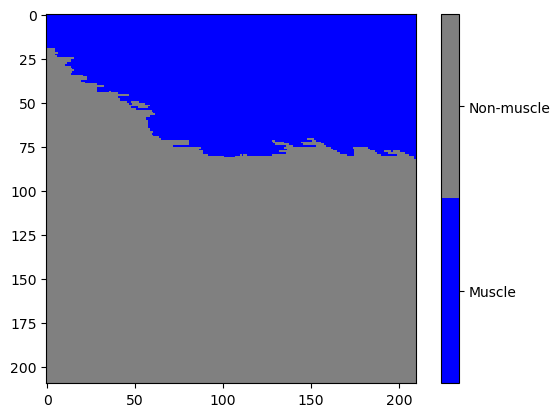

In [508]:
fill_all_holes(muscle_class, 1, 0, 550)
fill_all_holes(muscle_class, 0, 1, 4000)
cmap = colors.ListedColormap(['blue', 'gray'])
plt.imshow(muscle_class, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_ticks([0.25,0.75]) 
cbar.set_ticklabels(['Muscle', 'Non-muscle'])
plt.show()

In [476]:
sclera_class = np.argmin(sidsam_tanS[0],axis=2)

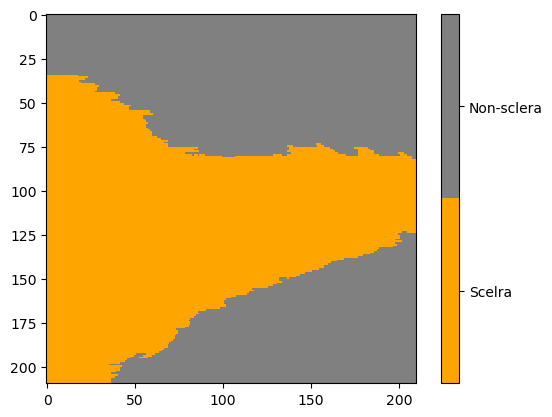

In [477]:
fill_all_holes(sclera_class, 1, 0, 800)
fill_all_holes(sclera_class, 0, 1, 5000)
cmap = colors.ListedColormap(['orange', 'gray'])
plt.imshow(sclera_class, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_ticks([0.25,0.75]) 
cbar.set_ticklabels(['Scelra', 'Non-sclera'])
plt.show()

In [478]:
choroid_class = np.argmin(sidsam_tanC[0],axis=2)

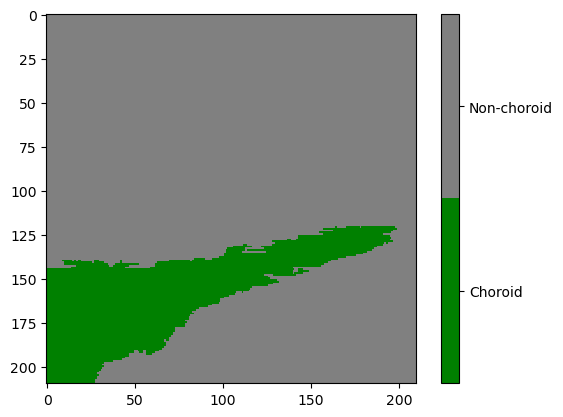

In [479]:
fill_all_holes(choroid_class, 1, 0, 1000) #replace non-choroid holes within choroid regions
fill_all_holes(choroid_class, 0, 1, 850)
cmap = colors.ListedColormap(['green', 'gray'])
plt.imshow(choroid_class, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_ticks([0.25,0.75]) 
cbar.set_ticklabels(['Choroid', 'Non-choroid'])
plt.show()

In [501]:
retina_class = np.argmin(sidsam_tanR[0],axis=2)

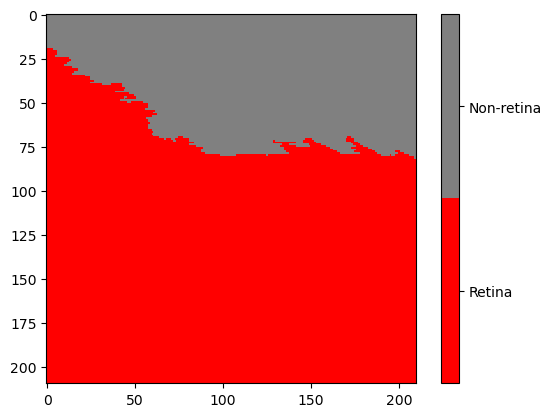

In [502]:
fill_all_holes(retina_class, 0, 1, 4000)
fill_all_holes(retina_class, 1, 0, 800)
retina_class = invert_matrix(retina_class)
cmap = colors.ListedColormap(['red', 'gray'])
plt.imshow(retina_class, cmap=cmap, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_ticks([0.25,0.75]) 
cbar.set_ticklabels(['Retina', 'Non-retina'])
plt.show()

In [493]:
retina_class

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [495]:
invert_matrix(retina_class)

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

### Overlapping

In [509]:
muscle_class = invert_matrix(muscle_class)

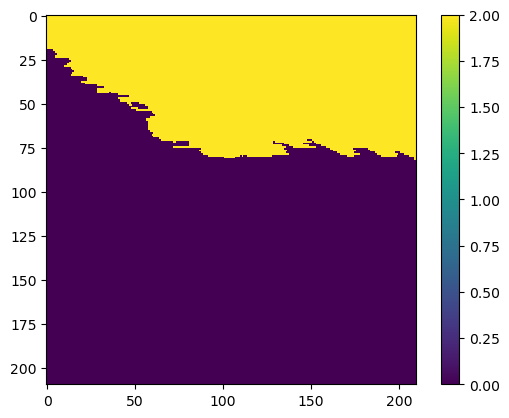

In [510]:
mix1 = muscle_class + retina_class # 2: muscle; 1: muscle+(retina); 0: retina. 1->2
mix1[mix1 ==1]=2
plt.imshow(mix1, cmap="viridis", interpolation='nearest')
cbar = plt.colorbar()
#cbar.set_ticks([0, 1, 2, 3]) 
#cbar.set_ticklabels(['Retina', 'Choroid', 'Sclera', 'Muscle'])
plt.show()

In [511]:
sclera_class = invert_matrix(sclera_class)
#sclera_class[sclera_class == 1] = 2 #2: sclera; 0: non-sclera

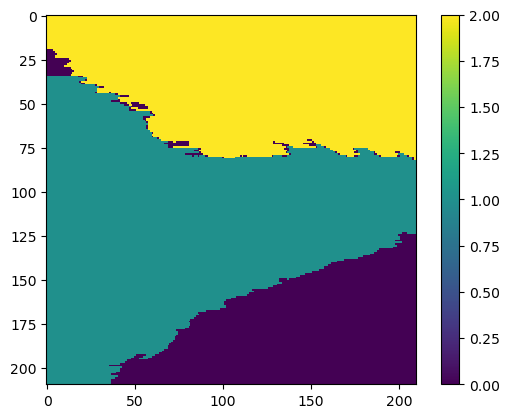

In [514]:
mix2 = sclera_class + mix1 #2: muscle; 1: sclera; 0: retina; 3: muscle+(sclera). 3->2
mix2[mix2 ==3]=2
plt.imshow(mix2, cmap="viridis", interpolation='nearest')
cbar = plt.colorbar()
#cbar.set_ticks([0, 1, 2, 3]) 
#cbar.set_ticklabels(['Retina', 'Choroid', 'Sclera', 'Muscle'])
plt.show()

In [515]:
choroid_class = invert_matrix(choroid_class)
choroid_class = change_val(choroid_class,1,2)

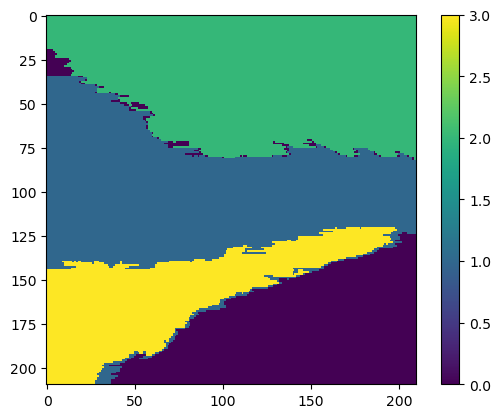

In [516]:
mix3 = choroid_class + mix2
#mix2[mix2 ==3]=2
plt.imshow(mix3, cmap="viridis", interpolation='nearest')
cbar = plt.colorbar()
#cbar.set_ticks([0, 1, 2, 3]) 
#cbar.set_ticklabels(['Retina', 'Choroid', 'Sclera', 'Muscle'])
plt.show()

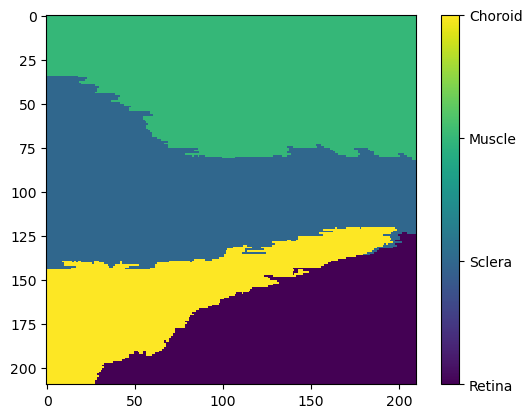

In [530]:
#cmap = colors.ListedColormap(['red', 'orange', 'blue', 'green'])
fill_all_holes(mix3, 0, 2, 900) #muscle-sclera -> muscle
fill_all_holes(mix3, 1, 0, 800) #choroid-retina -> retina
plt.imshow(mix3, cmap="viridis", interpolation='nearest')
cbar = plt.colorbar()
cbar.set_ticks([0, 1, 2, 3]) 
cbar.set_ticklabels(['Retina', 'Sclera', 'Muscle', 'Choroid'])
plt.show()

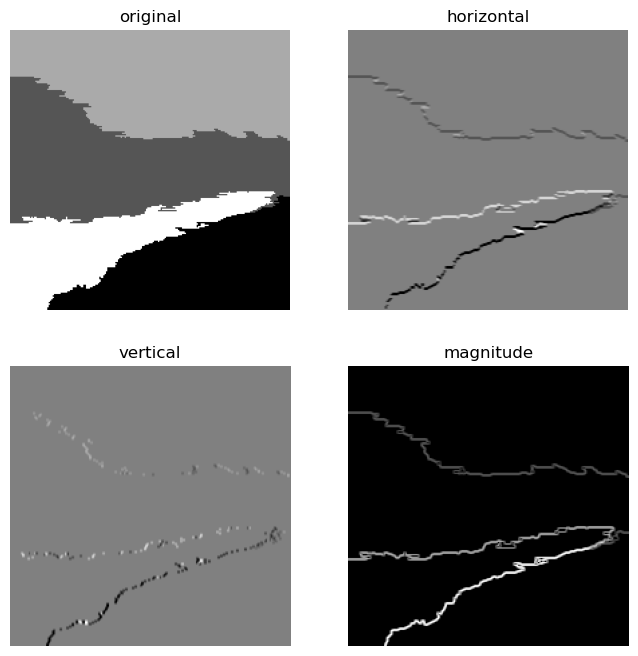

In [531]:
from scipy import ndimage, datasets
boundary = scipy.ndimage.sobel(mix3)
sobel_h = scipy.ndimage.sobel(mix3, 0) # horizontal gradient
sobel_v = scipy.ndimage.sobel(mix3, 1)  # vertical gradient
magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
magnitude *= 255.0 / np.max(magnitude)  # normalization
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.gray()  # show the filtered result in grayscale
axs[0, 0].imshow(mix3)
axs[0, 1].imshow(sobel_h)
axs[1, 0].imshow(sobel_v)
axs[1, 1].imshow(magnitude)
titles = ["original", "horizontal", "vertical", "magnitude"]
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i])
    ax.axis("off")
plt.show()

In [532]:
magnitude[magnitude != 0 ]=4
fig_w_boundary = magnitude+mix3
fig_w_boundary

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [3., 3., 3., ..., 0., 0., 0.],
       [3., 3., 3., ..., 0., 0., 0.],
       [3., 3., 3., ..., 0., 0., 0.]])

In [524]:
def set_boundary_color(matrix):
    return np.where(matrix > 3, 4, matrix)

In [533]:
fig_w_boundary = np.where(fig_w_boundary > 3, 4, fig_w_boundary)

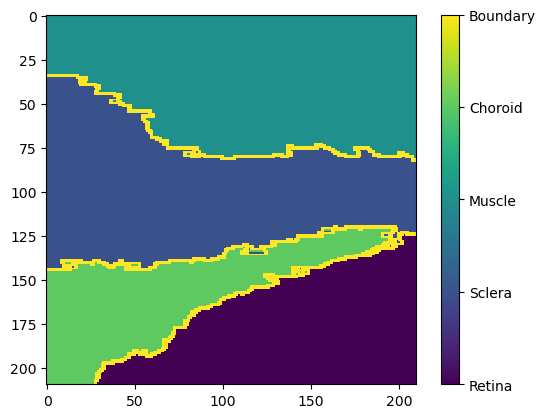

In [534]:
plt.imshow(fig_w_boundary, cmap="viridis", interpolation='nearest')
cbar = plt.colorbar()
cbar.set_ticks([0, 1, 2, 3, 4]) 
cbar.set_ticklabels(['Retina', 'Sclera', 'Muscle', 'Choroid', 'Boundary'])
plt.show()